In [1]:
# ! pip install gym==0.19.0 matplotlib tqdm loguru

In [1]:
import math
import random
from collections import defaultdict, deque
from itertools import product

import gym
import numpy as np
from loguru import logger
from IPython.display import display
from tqdm import tqdm
import matplotlib.pyplot as plt

# Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
* hit  — взять ещё одну карту;
* stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; 
* при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [2]:
env = gym.make('Blackjack-v0', natural=True)

In [3]:
# кастомный argmax -- np.argmax возвращает индекс первого из максимальных значений (если их больше 1)
def random_argmax(probs):
    max_p = max(probs)
    return random.choice([i for i, p in enumerate(probs) if p == max_p])

In [4]:
def round_episodes(n_episodes, n_round=1e4):
    return int(math.ceil(n_episodes / n_round) * n_round)

In [5]:
class BlackJackActor:
    def __init__(self, env, policy_func):
        self.env = env
        self.policy_func = policy_func
        self.n_actions = self.env.action_space.n
        
    def best_action(self, obs):
        return random_argmax(self.policy_func(obs))    
        
    def sample_action(self, obs):
        return random.choices(range(self.n_actions), weights=self.policy_func(obs), k=1)[0]
        
    def play_episode(self, mode):
        self.env.reset()
        episode = []
        done = False
        obs = self.env._get_obs()
        while not done:
            if mode == "predict":
                action = self.best_action(obs)
            elif mode == "sample":
                action = self.sample_action(obs)
            else:
                raise ValueError("Unknown play episode mode")
            next_obs, reward, done, _ = self.env.step(action)
            episode.append((obs, action, next_obs, reward))
            obs = next_obs
        return episode

* Оценка методом Монте-Карло + отрисовка результатов

In [6]:
def mc_eval(actor, n_episodes, n_round=10_000):
    n_episodes = round_episodes(n_episodes)
    rewards = np.zeros(n_episodes)
    for i in tqdm(range(int(n_episodes / n_round))):
        for j in range(n_round):
            *_, rewards[i * n_round + j] = actor.play_episode(mode="predict")[-1]
        
    return np.cumsum(rewards) / (np.arange(len(rewards)) + 1)

In [7]:
def draw_results(avg_reward):
    fig = plt.figure(figsize=(20,10))

    ax = fig.add_subplot(211)
    ax.plot(avg_reward)
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Average reward")

#     ax = fig.add_subplot(212)
#     idx_to_draw = np.arange(int(len(avg_reward) / 2), int(len(avg_reward)))
#     ax.plot(idx_to_draw, avg_reward[idx_to_draw])
#     ax.set_xlabel("Episodes (the second half)")
#     ax.set_ylabel("Average reward")

    display(fig)
    logger.info(f"Averaged reward = {avg_reward[-1]}")
    plt.close() 

* Rule-based policy - по трэшхолду

In [8]:
def threshold_policy(stop_hand):
    def _policy(obs):
        # sum_hand, dealer_first, usable_ace_flag
        sum_hand, _, _ = obs
        return [0, 1] if sum_hand < stop_hand else [1, 0]
    return _policy

* Оценим простую стратегию с трешхолдом = 19

100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


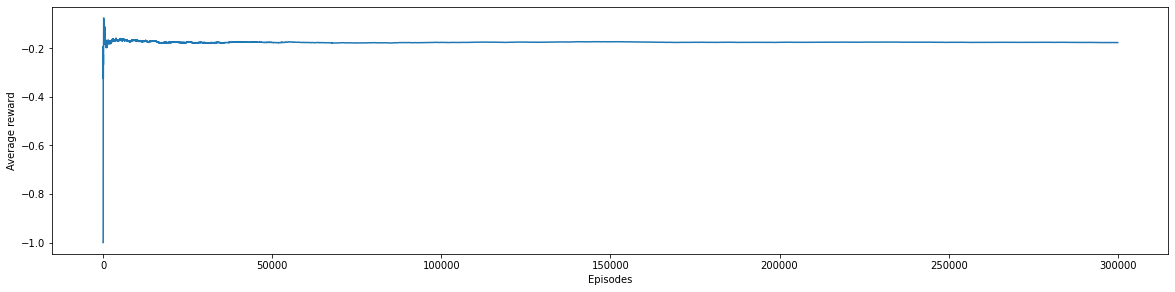

2022-01-10 16:27:12.986 | INFO     | __main__:draw_results:16 - Averaged reward = -0.17683833333333332


In [9]:
random.seed(100)
env = gym.make('Blackjack-v0', natural=True)

actor = BlackJackActor(env=env, policy_func=threshold_policy(stop_hand=19))
cum_avg_reward = mc_eval(actor, n_episodes=300_000)
draw_results(cum_avg_reward)

* Monte-Carlo Control - off/on policy

In [10]:
def random_policy(n_actions):
    probs = [1. / n_actions] * n_actions
    def _policy(obs):
        return probs
    return _policy

In [11]:
def eps_greedy_policy(Q, eps, n_actions):
    probs = [eps / n_actions] * n_actions
    def _policy(obs):
        probs[random_argmax(Q[obs])] += 1 - eps
        return probs
    return _policy

In [12]:
def mcc_off_policy(env, n_episodes, eps=0.0, gamma=1.0):
    n_episodes = round_episodes(n_episodes)
    Q = defaultdict(lambda: [0.] * env.action_space.n)
    C = defaultdict(lambda: [0.] * env.action_space.n)
    
    target_policy = eps_greedy_policy(Q, eps, env.action_space.n)
    behavior_policy = random_policy(env.action_space.n)
    actor = BlackJackActor(env=env, policy_func=behavior_policy)

    for _ in tqdm(range(int(n_episodes / 1e4))):
        for _ in range(int(1e4)):
            episode = actor.play_episode(mode="sample")

            G = 0.0
            W = 1.0
            while episode:
                obs, action, *_, reward = episode.pop()
                G = gamma * G + reward
                C[obs][action] += W
                Q[obs][action] += (W / C[obs][action]) * (G - Q[obs][action])
                if action !=  random_argmax(target_policy(obs)):
                    break
                W /= behavior_policy(obs)[action]
    
    actor.policy_func = target_policy
    return Q, actor

In [13]:
def mcc_on_policy(env, n_episodes, eps=0.0, gamma=1.0):
    n_episodes = round_episodes(n_episodes)
    Q = defaultdict(lambda: [0.] * env.action_space.n)
    R_sum = defaultdict(lambda: [0.] * env.action_space.n)
    R_count = defaultdict(lambda: [0] * env.action_space.n)
    
    actor = BlackJackActor(env=env, policy_func=eps_greedy_policy(Q, eps, env.action_space.n))

    for _ in tqdm(range(int(n_episodes / 1e4))):
        for _ in range(int(1e4)):
            episode = actor.play_episode(mode="sample")
            observations = [obs for obs, *_ in episode]
            i = 1
            G = 0.
            while episode:
                obs, action, *_, reward = episode.pop()
                G = gamma * G + reward
                if not obs in observations[:-i]:
                    R_sum[obs][action] += G
                    R_count[obs][action] += 1
                    Q[obs][action] = R_sum[obs][action] / R_count[obs][action]

                i += 1
        
    return Q, actor

* Оценим качество стратегий, обученных методом MCC

In [14]:
random.seed(100)
env = gym.make('Blackjack-v0', natural=True)

Q, actor = mcc_off_policy(env, n_episodes=300_000)

100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


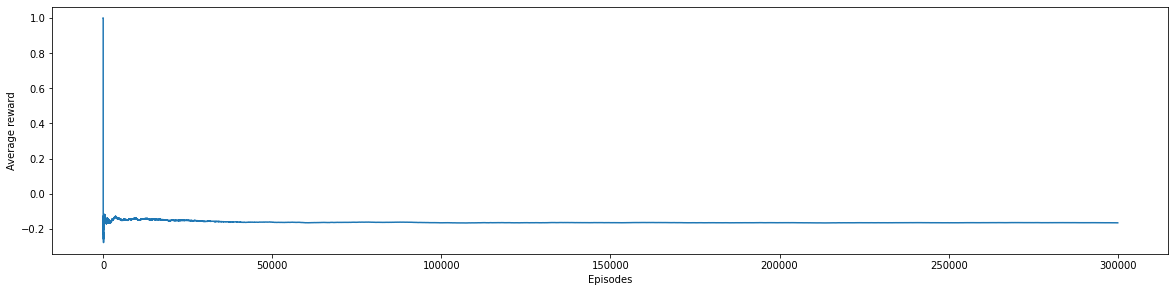

2022-01-10 16:27:47.349 | INFO     | __main__:draw_results:16 - Averaged reward = -0.16499666666666668


In [15]:
cum_avg_reward = mc_eval(actor, n_episodes=300_000)
draw_results(cum_avg_reward)

In [17]:
random.seed(100)
env = gym.make('Blackjack-v0', natural=True)

Q, actor = mcc_on_policy(env, n_episodes=300_000)

100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


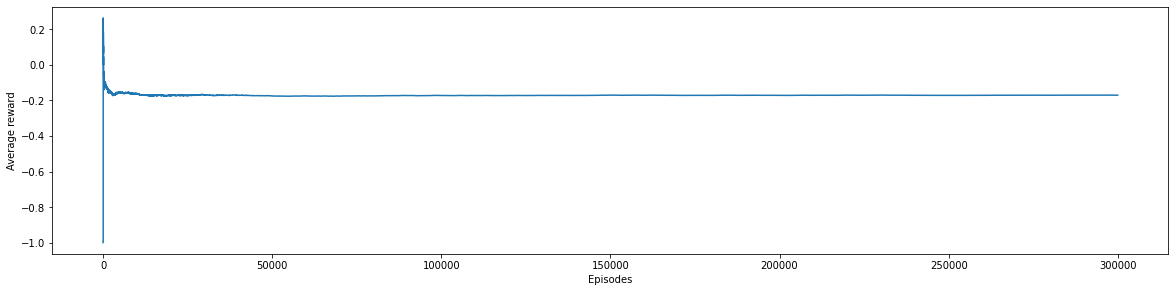

2022-01-10 16:28:43.750 | INFO     | __main__:draw_results:16 - Averaged reward = -0.17014


In [18]:
cum_avg_reward = mc_eval(actor, n_episodes=300_000)
draw_results(cum_avg_reward)

* Попробуем подобрать гиперпараметры

In [19]:
eps_ = [0.05]
gamma_ = [1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.85, 0.8]

In [20]:
for eps, gamma in tqdm(product(eps_, gamma_), total=len(eps_)*len(gamma_), desc="mcc_on_poicy"):
    random.seed(100)
    env = gym.make('Blackjack-v0', natural=True)
    Q, actor = mcc_on_policy(env, n_episodes=100_000, eps=eps, gamma=gamma)
    cum_avg_reward = mc_eval(actor, n_episodes=100_000)
    logger.info(f"eps={eps}, gamma={gamma}: avg reward = {cum_avg_reward[-1]}")

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

100%|██████████| 10/10 [00:04<00:00,  2.03it/s]
2022-01-10 16:28:54.509 | INFO     | __main__:<module>:6 - eps=0.05, gamma=1.0: avg reward = -0.166885
100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

100%|██████████| 10/10 [00:04<00:00,  2.08it/s]
2022-01-10 16:29:04.996 | INFO     | __main__:<module>:6 - eps=0.05, gamma=0.98: avg reward = -0.164225
100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

100%|██████████| 10/10 [00:04<00:00,  2.04it/s]
2022-01-10 16:29:15.547 | INFO     | __main__:<module>:6 - eps=0.05, gamma=0.96: avg reward = -0.168925
100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]
2022-01-10 16:29:26.955 | INFO     | __main__:<module>:6 - eps=0.05, gamma=0.94: avg reward = -0.16198
100%|██████████| 10/10 [00:06<00:00,  1.50it/s]

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]
2022-01-10 16:29:38.989 | INFO     | __main__:<module>:6 - eps=0.05, gamma=0.92: avg reward = -0.1600

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]
2022-01-10 16:30:02.241 | INFO     | __main__:<module>:6 - eps=0.05, gamma=0.85: avg reward = -0.16529
100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]
2022-01-10 16:30:12.873 | INFO     | __main__:<module>:6 - eps=0.05, gamma=0.8: avg reward = -0.16306
mcc_on_poicy: 100%|██████████| 8/8 [01:29<00:00, 11.14s/it]


In [23]:
eps_ = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
gamma_ = [0.92]

In [24]:
for eps, gamma in tqdm(product(eps_, gamma_), total=len(eps_)*len(gamma_), desc="mcc_on_poicy"):
    random.seed(100)
    env = gym.make('Blackjack-v0', natural=True)
    Q, actor = mcc_on_policy(env, n_episodes=100_000, eps=eps, gamma=gamma)
    cum_avg_reward = mc_eval(actor, n_episodes=100_000)
    logger.info(f"eps={eps}, gamma={gamma}: avg reward = {cum_avg_reward[-1]}")

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]
2022-01-10 16:31:35.531 | INFO     | __main__:<module>:6 - eps=0.0, gamma=0.92: avg reward = -0.162495
100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
2022-01-10 16:31:47.519 | INFO     | __main__:<module>:6 - eps=0.05, gamma=0.92: avg reward = -0.165055
100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

100%|██████████| 10/10 [00:05<00:00,  1.85it/s]
2022-01-10 16:31:59.321 | INFO     | __main__:<module>:6 - eps=0.1, gamma=0.92: avg reward = -0.16186
100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

100%|██████████| 10/10 [00:05<00:00,  1.83it/s]
2022-01-10 16:32:11.326 | INFO     | __main__:<module>:6 - eps=0.15, gamma=0.92: avg reward = -0.162025
100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]
2022-01-10 16:32:23.546 | INFO     | __main__:<module>:6 - eps=0.2, gamma=0.92: avg reward = -0.16533


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]
2022-01-10 16:32:47.779 | INFO     | __main__:<module>:6 - eps=0.3, gamma=0.92: avg reward = -0.16888
100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]
2022-01-10 16:32:59.801 | INFO     | __main__:<module>:6 - eps=0.35, gamma=0.92: avg reward = -0.16795
100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]
2022-01-10 16:33:12.117 | INFO     | __main__:<module>:6 - eps=0.4, gamma=0.92: avg reward = -0.168265
mcc_on_poicy: 100%|██████████| 9/9 [01:47<00:00, 11.95s/it]


* Подбор гиперпараметров не дает существенного прироста (кажется, качество колеблется в пределах погрешности), тем не менее, оценим качество финальной стратегии

In [25]:
Q, actor = mcc_on_policy(env, eps=0.1, gamma=0.92, n_episodes=300_000)

100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


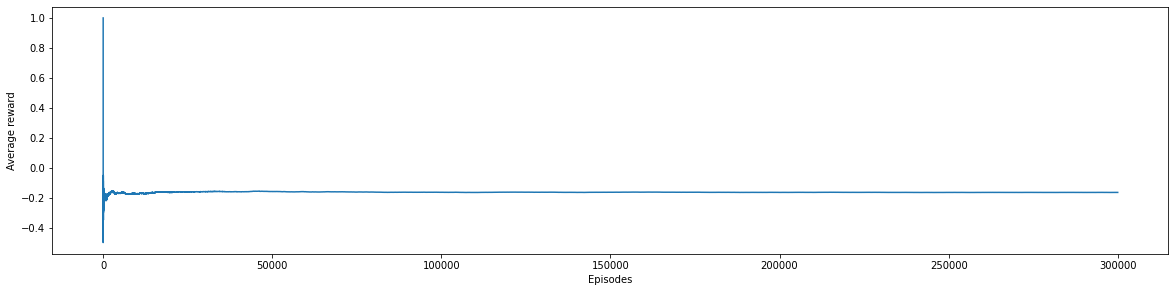

2022-01-10 16:34:03.259 | INFO     | __main__:draw_results:16 - Averaged reward = -0.165045


In [26]:
cum_avg_reward = mc_eval(actor, n_episodes=300_000)
draw_results(cum_avg_reward)